# NCAAM Matchup Analysis: Common Opponent Network

This notebook analyzes NCAAM matchups by identifying common opponents and comparing team performance. It uses network analysis to visualize team connections and provides tools to find betting edges based on indirect comparisons.

## Features:
1. **Team Network Visualization** - See how teams are connected through games
2. **Common Opponent Finder** - Identify shared opponents between any two teams
3. **Comparative Performance Analysis** - Compare how teams performed against common opponents
4. **Matchup Edge Detection** - Identify potential betting opportunities based on indirect comparisons


In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display, HTML
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully")


Libraries loaded successfully


In [2]:
# Load NCAAM season data
project_root = Path().resolve().parent
data_file = project_root / 'data' / 'results' / 'ncaam_season_results.xlsx'

df = pd.read_excel(data_file)

# Convert game_date to datetime
df['game_date'] = pd.to_datetime(df['game_date'])

# Filter to completed games with scores
df_completed = df[
    df['home_score'].notna() & 
    df['away_score'].notna() & 
    df['closing_spread'].notna()
].copy()

print(f"Total games loaded: {len(df)}")
print(f"Completed games with scores and spreads: {len(df_completed)}")
print(f"Unique teams: {len(set(df_completed['home_team'].unique()) | set(df_completed['away_team'].unique()))}")
print(f"Date range: {df_completed['game_date'].min().date()} to {df_completed['game_date'].max().date()}")

# Display sample of data
print("\nSample data:")
df_completed.head()


Total games loaded: 2280
Completed games with scores and spreads: 2279
Unique teams: 365
Date range: 2025-11-03 to 2026-01-05

Sample data:


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-11-03,Colorado Buffaloes,Montana St Bobcats,-12.5,84,78,-6.5
1,2025-11-03,Radford Highlanders,Western Illinois Leathernecks,-16.5,80,75,-11.5
2,2025-11-03,George Mason Patriots,Wofford Terriers,-14.5,70,46,9.5
3,2025-11-03,Baylor Bears,UT Rio Grande Valley Vaqueros,-24.5,96,81,-9.5
4,2025-11-03,Wisconsin Badgers,Campbell Fighting Camels,-20.5,96,64,11.5


## 1. Build Team Network

Create a network graph where teams are nodes and games are edges. This helps visualize team connections and identify common opponents.


In [3]:
# Build network graph
# Nodes = teams, Edges = games played between teams
G = nx.Graph()

# Add edges for each game (undirected graph)
for _, row in df_completed.iterrows():
    home = row['home_team']
    away = row['away_team']
    
    # Add edge if it doesn't exist, or increment weight if it does
    if G.has_edge(home, away):
        G[home][away]['weight'] += 1
        if 'games' not in G[home][away]:
            G[home][away]['games'] = []
        G[home][away]['games'].append({
            'date': row['game_date'],
            'home_score': row['home_score'],
            'away_score': row['away_score'],
            'spread': row['closing_spread'],
            'spread_result': row['spread_result_difference']
        })
    else:
        G.add_edge(home, away, weight=1, games=[{
            'date': row['game_date'],
            'home_score': row['home_score'],
            'away_score': row['away_score'],
            'spread': row['closing_spread'],
            'spread_result': row['spread_result_difference']
        }])

print(f"Network created:")
print(f"  Nodes (teams): {G.number_of_nodes()}")
print(f"  Edges (matchups): {G.number_of_edges()}")
print(f"  Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f} games per team")


Network created:
  Nodes (teams): 365
  Edges (matchups): 2268
  Average degree: 12.43 games per team


In [4]:
# Calculate network statistics
degrees = dict(G.degree())
degree_df = pd.DataFrame([
    {'team': team, 'games_played': degree} 
    for team, degree in degrees.items()
]).sort_values('games_played', ascending=False)

print("Teams with most games (most connected):")
print(degree_df.head(15))

print(f"\nNetwork density: {nx.density(G):.4f}")
print(f"(1.0 = complete graph where every team plays every other team)")


Teams with most games (most connected):
                             team  games_played
152              Gonzaga Bulldogs            17
75               Coppin St Eagles            16
46              Oregon St Beavers            16
68               Murray St Racers            16
84          Washington St Cougars            16
258        Loyola Marymount Lions            16
301           Santa Clara Broncos            16
190           Cal Baptist Lancers            16
195  Maryland-Eastern Shore Hawks            15
315             San Diego Toreros            15
64             Seton Hall Pirates            15
124            DePaul Blue Demons            15
202      North Carolina Tar Heels            15
89        Louisiana Ragin' Cajuns            15
140          Nebraska Cornhuskers            15

Network density: 0.0341
(1.0 = complete graph where every team plays every other team)


## 2. Common Opponent Analysis Functions

Functions to find common opponents and compare team performance.


In [5]:
def get_team_opponents(team_name, df_data):
    """Get all opponents a team has played"""
    home_games = df_data[df_data['home_team'] == team_name]
    away_games = df_data[df_data['away_team'] == team_name]
    
    opponents = set()
    opponents.update(home_games['away_team'].unique())
    opponents.update(away_games['home_team'].unique())
    
    return sorted(list(opponents))


def find_common_opponents(team_a, team_b, df_data):
    """Find common opponents between two teams"""
    opponents_a = set(get_team_opponents(team_a, df_data))
    opponents_b = set(get_team_opponents(team_b, df_data))
    return sorted(list(opponents_a & opponents_b))


def get_team_performance_vs_opponent(team_name, opponent_name, df_data):
    """Get team's performance against a specific opponent"""
    games = df_data[
        ((df_data['home_team'] == team_name) & (df_data['away_team'] == opponent_name)) |
        ((df_data['away_team'] == team_name) & (df_data['home_team'] == opponent_name))
    ].copy()
    
    if len(games) == 0:
        return None
    
    results = []
    for _, game in games.iterrows():
        was_home = game['home_team'] == team_name
        
        if was_home:
            team_score = game['home_score']
            opp_score = game['away_score']
            spread = game['closing_spread']
            spread_result = game['spread_result_difference']
        else:
            team_score = game['away_score']
            opp_score = game['home_score']
            spread = -game['closing_spread']
            spread_result = -game['spread_result_difference']
        
        won = team_score > opp_score
        covered = spread_result > 0
        push = spread_result == 0
        
        results.append({
            'date': game['game_date'],
            'was_home': was_home,
            'team_score': team_score,
            'opp_score': opp_score,
            'spread': spread,
            'spread_result': spread_result,
            'won': won,
            'covered': covered,
            'push': push,
            'margin': team_score - opp_score
        })
    
    return pd.DataFrame(results)


def compare_teams_vs_common_opponents(team_a, team_b, df_data):
    """Compare two teams' performance against common opponents"""
    common_opponents = find_common_opponents(team_a, team_b, df_data)
    
    if len(common_opponents) == 0:
        return None, None
    
    comparison_data = []
    
    for opponent in common_opponents:
        team_a_games = get_team_performance_vs_opponent(team_a, opponent, df_data)
        team_b_games = get_team_performance_vs_opponent(team_b, opponent, df_data)
        
        if team_a_games is None or team_b_games is None or len(team_a_games) == 0 or len(team_b_games) == 0:
            continue
        
        # Team A stats
        team_a_wins = team_a_games['won'].sum()
        team_a_covers = team_a_games['covered'].sum()
        team_a_pushes = team_a_games['push'].sum()
        team_a_total = len(team_a_games)
        team_a_home_games = team_a_games['was_home'].sum()
        team_a_away_games = team_a_total - team_a_home_games
        team_a_win_pct = (team_a_wins / team_a_total * 100) if team_a_total > 0 else 0
        team_a_cover_pct = (team_a_covers / (team_a_total - team_a_pushes) * 100) if (team_a_total - team_a_pushes) > 0 else 0
        team_a_avg_margin = team_a_games['margin'].mean()
        
        # Calculate adjusted margin for Team A (home = -5, away = +5)
        team_a_adjusted_margins = team_a_games['margin'].copy()
        team_a_adjusted_margins = team_a_adjusted_margins + team_a_games['was_home'].map({True: -5, False: +5})
        team_a_avg_adjusted_margin = team_a_adjusted_margins.mean()
        
        team_a_avg_spread_result = team_a_games[~team_a_games['push']]['spread_result'].mean() if len(team_a_games[~team_a_games['push']]) > 0 else 0
        
        # Team B stats
        team_b_wins = team_b_games['won'].sum()
        team_b_covers = team_b_games['covered'].sum()
        team_b_pushes = team_b_games['push'].sum()
        team_b_total = len(team_b_games)
        team_b_home_games = team_b_games['was_home'].sum()
        team_b_away_games = team_b_total - team_b_home_games
        team_b_win_pct = (team_b_wins / team_b_total * 100) if team_b_total > 0 else 0
        team_b_cover_pct = (team_b_covers / (team_b_total - team_b_pushes) * 100) if (team_b_total - team_b_pushes) > 0 else 0
        team_b_avg_margin = team_b_games['margin'].mean()
        
        # Calculate adjusted margin for Team B (home = -5, away = +5)
        team_b_adjusted_margins = team_b_games['margin'].copy()
        team_b_adjusted_margins = team_b_adjusted_margins + team_b_games['was_home'].map({True: -5, False: +5})
        team_b_avg_adjusted_margin = team_b_adjusted_margins.mean()
        
        team_b_avg_spread_result = team_b_games[~team_b_games['push']]['spread_result'].mean() if len(team_b_games[~team_b_games['push']]) > 0 else 0
        
        # Calculate differentials
        win_pct_diff = team_a_win_pct - team_b_win_pct
        cover_pct_diff = team_a_cover_pct - team_b_cover_pct
        margin_diff = team_a_avg_margin - team_b_avg_margin
        adjusted_margin_diff = team_a_avg_adjusted_margin - team_b_avg_adjusted_margin  # Home/away adjusted
        spread_result_diff = team_a_avg_spread_result - team_b_avg_spread_result
        
        # Store game details for later display
        team_a_game_details = team_a_games[['date', 'was_home', 'team_score', 'opp_score', 'margin', 'covered', 'spread']].copy()
        team_b_game_details = team_b_games[['date', 'was_home', 'team_score', 'opp_score', 'margin', 'covered', 'spread']].copy()
        
        comparison_data.append({
            'opponent': opponent,
            'team_a_games': team_a_total,
            'team_b_games': team_b_total,
            'team_a_home': team_a_home_games,
            'team_a_away': team_a_away_games,
            'team_b_home': team_b_home_games,
            'team_b_away': team_b_away_games,
            'team_a_win_pct': round(team_a_win_pct, 1),
            'team_b_win_pct': round(team_b_win_pct, 1),
            'win_pct_diff': round(win_pct_diff, 1),
            'team_a_cover_pct': round(team_a_cover_pct, 1),
            'team_b_cover_pct': round(team_b_cover_pct, 1),
            'cover_pct_diff': round(cover_pct_diff, 1),
            'team_a_avg_margin': round(team_a_avg_margin, 1),
            'team_b_avg_margin': round(team_b_avg_margin, 1),
            'margin_diff': round(margin_diff, 1),
            'team_a_avg_adjusted_margin': round(team_a_avg_adjusted_margin, 1),
            'team_b_avg_adjusted_margin': round(team_b_avg_adjusted_margin, 1),
            'adjusted_margin_diff': round(adjusted_margin_diff, 1),
            'team_a_avg_spread_result': round(team_a_avg_spread_result, 2),
            'team_b_avg_spread_result': round(team_b_avg_spread_result, 2),
            'spread_result_diff': round(spread_result_diff, 2),
            'team_a_game_details': team_a_game_details,
            'team_b_game_details': team_b_game_details
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Calculate overall summary
    if len(comparison_df) > 0:
        summary = {
            'common_opponents_count': len(common_opponents),
            'avg_win_pct_diff': round(comparison_df['win_pct_diff'].mean(), 1),
            'avg_cover_pct_diff': round(comparison_df['cover_pct_diff'].mean(), 1),
            'avg_margin_diff': round(comparison_df['margin_diff'].mean(), 1),
            'avg_adjusted_margin_diff': round(comparison_df['adjusted_margin_diff'].mean(), 1),  # Home/away adjusted
            'avg_spread_result_diff': round(comparison_df['spread_result_diff'].mean(), 2),
            'team_a_better_win_pct': (comparison_df['win_pct_diff'] > 0).sum(),
            'team_b_better_win_pct': (comparison_df['win_pct_diff'] < 0).sum(),
            'team_a_better_cover_pct': (comparison_df['cover_pct_diff'] > 0).sum(),
            'team_b_better_cover_pct': (comparison_df['cover_pct_diff'] < 0).sum()
        }
    else:
        summary = None
    
    return comparison_df, summary


print("Common opponent analysis functions defined")


Common opponent analysis functions defined


## 3. Interactive Matchup Analyzer

Use this tool to compare any two teams based on their common opponents.


In [6]:
# Get all unique teams
all_teams = sorted(set(df_completed['home_team'].unique()) | set(df_completed['away_team'].unique()))

# Create output area
output = widgets.Output()

def analyze_matchup(team_a, team_b):
    """Analyze matchup between two teams"""
    with output:
        output.clear_output(wait=True)
        
        if team_a == team_b:
            print("⚠️ Please select two different teams.")
            return
        
        print("="*100)
        print(f"MATCHUP ANALYSIS: {team_a.upper()} vs {team_b.upper()}")
        print("="*100)
        
        # Find common opponents
        common_opponents = find_common_opponents(team_a, team_b, df_completed)
        
        if len(common_opponents) == 0:
            print(f"\n❌ No common opponents found between {team_a} and {team_b}.")
            print("These teams have not played any of the same opponents this season.")
            return
        
        print(f"\n✓ Found {len(common_opponents)} common opponent(s): {', '.join(common_opponents)}")
        
        # Get comparison
        comparison_df, summary = compare_teams_vs_common_opponents(team_a, team_b, df_completed)
        
        if comparison_df is None or len(comparison_df) == 0:
            print("\n⚠️ Could not generate comparison data.")
            return
        
        # Display summary
        print("\n" + "="*100)
        print("SUMMARY")
        print("="*100)
        print(f"\nAverage Win % Difference: {summary['avg_win_pct_diff']:+.1f}%")
        print(f"  ({team_a} better: {summary['team_a_better_win_pct']}, {team_b} better: {summary['team_b_better_win_pct']})")
        print(f"\nAverage Cover % Difference: {summary['avg_cover_pct_diff']:+.1f}%")
        print(f"  ({team_a} better: {summary['team_a_better_cover_pct']}, {team_b} better: {summary['team_b_better_cover_pct']})")
        print(f"\nAverage Margin Difference: {summary['avg_margin_diff']:+.1f} points (raw)")
        print(f"Average Adjusted Margin Difference: {summary['avg_adjusted_margin_diff']:+.1f} points (home/away adjusted)")
        print(f"Average Spread Result Difference: {summary['avg_spread_result_diff']:+.2f} points")
        
        # Interpretation
        print("\n" + "="*100)
        print("INTERPRETATION")
        print("="*100)
        
        if summary['avg_cover_pct_diff'] > 10:
            print(f"\n✅ {team_a} has significantly better ATS performance vs common opponents")
            print(f"   ({summary['avg_cover_pct_diff']:.1f}% better cover rate)")
        elif summary['avg_cover_pct_diff'] < -10:
            print(f"\n✅ {team_b} has significantly better ATS performance vs common opponents")
            print(f"   ({abs(summary['avg_cover_pct_diff']):.1f}% better cover rate)")
        else:
            print(f"\n⚖️ Teams have similar ATS performance vs common opponents")
        
        if summary['avg_adjusted_margin_diff'] > 5:
            print(f"\n✅ {team_a} wins by larger margins vs common opponents (adjusted for home/away)")
            print(f"   (Average {summary['avg_adjusted_margin_diff']:.1f} points more)")
        elif summary['avg_adjusted_margin_diff'] < -5:
            print(f"\n✅ {team_b} wins by larger margins vs common opponents (adjusted for home/away)")
            print(f"   (Average {abs(summary['avg_adjusted_margin_diff']):.1f} points more)")
        
        # PROJECTION SECTION
        print("\n" + "="*100)
        print("MATCHUP PROJECTION (Based on Common Opponent Analysis)")
        print("="*100)
        print("\nNote: Margins are adjusted for home/away (home -5pts, away +5pts) to account for")
        print("college basketball home court advantage.")
        
        # Projected margin (using HOME/AWAY ADJUSTED average margin difference)
        projected_margin = summary['avg_adjusted_margin_diff']
        
        # Calculate win probability based on historical win % difference
        # Convert win % difference to probability (assuming normal distribution approximation)
        base_prob = 50.0  # Starting at 50/50
        win_prob_adjustment = summary['avg_win_pct_diff'] * 0.5  # Scale the difference
        team_a_win_prob = base_prob + win_prob_adjustment
        team_b_win_prob = 100 - team_a_win_prob
        
        # Projected spread (negative means team_a is favored, positive means team_b is favored)
        # Use margin difference as basis, but adjust for typical spread ranges
        projected_spread = -projected_margin  # Negative = team_a favored
        
        # ATS projection based on cover % difference
        team_a_cover_prob = 50.0 + (summary['avg_cover_pct_diff'] * 0.5)
        team_b_cover_prob = 100 - team_a_cover_prob
        
        # Determine projected winner (neutral court)
        if projected_margin > 0:
            projected_winner = team_a
            projected_margin_display = f"{team_a} by {abs(projected_margin):.1f}"
        elif projected_margin < 0:
            projected_winner = team_b
            projected_margin_display = f"{team_b} by {abs(projected_margin):.1f}"
        else:
            projected_winner = "Tie"
            projected_margin_display = "Tie"
        
        # Calculate home/away scenarios
        # Home team gets 5 points more favorable margin (5 points higher)
        # Away team gets 5 points less favorable margin (5 points lower)
        # If Team A is home: their margin increases by 5 (more favorable = higher number)
        margin_if_team_a_home = projected_margin + 5
        if margin_if_team_a_home > 0:
            winner_if_team_a_home = team_a
            margin_display_a_home = f"{team_a} by {abs(margin_if_team_a_home):.1f}"
        elif margin_if_team_a_home < 0:
            winner_if_team_a_home = team_b
            margin_display_a_home = f"{team_b} by {abs(margin_if_team_a_home):.1f}"
        else:
            winner_if_team_a_home = "Tie"
            margin_display_a_home = "Tie"
        
        # If Team B is home (Team A is away): Team A's margin decreases by 5 (less favorable = lower number)
        margin_if_team_b_home = projected_margin - 5
        if margin_if_team_b_home > 0:
            winner_if_team_b_home = team_a
            margin_display_b_home = f"{team_a} by {abs(margin_if_team_b_home):.1f}"
        elif margin_if_team_b_home < 0:
            winner_if_team_b_home = team_b
            margin_display_b_home = f"{team_b} by {abs(margin_if_team_b_home):.1f}"
        else:
            winner_if_team_b_home = "Tie"
            margin_display_b_home = "Tie"
        
        # Display projections
        print(f"\n📊 PROJECTED OUTCOME (Neutral Court):")
        print(f"   Winner: {projected_winner}")
        print(f"   Margin: {projected_margin_display} points")
        
        print(f"\n📊 PROJECTED OUTCOME (If {team_a} is Home):")
        print(f"   Winner: {winner_if_team_a_home}")
        print(f"   Margin: {margin_display_a_home} points")
        
        print(f"\n📊 PROJECTED OUTCOME (If {team_b} is Home):")
        print(f"   Winner: {winner_if_team_b_home}")
        print(f"   Margin: {margin_display_b_home} points")
        
        print(f"\n📈 WIN PROBABILITY:")
        print(f"   {team_a}: {team_a_win_prob:.1f}%")
        print(f"   {team_b}: {team_b_win_prob:.1f}%")
        
        print(f"\n💰 ATS PROJECTION:")
        print(f"   {team_a} Cover Probability: {team_a_cover_prob:.1f}%")
        print(f"   {team_b} Cover Probability: {team_b_cover_prob:.1f}%")
        
        # Confidence indicator based on number of common opponents
        if summary['common_opponents_count'] >= 5:
            confidence = "High"
            confidence_note = "Strong projection based on 5+ common opponents"
        elif summary['common_opponents_count'] >= 3:
            confidence = "Medium"
            confidence_note = "Moderate projection based on 3-4 common opponents"
        else:
            confidence = "Low"
            confidence_note = "Limited projection based on few common opponents"
        
        print(f"\n⚠️  CONFIDENCE LEVEL: {confidence}")
        print(f"   {confidence_note}")
        print(f"   Common Opponents: {summary['common_opponents_count']}")
        
        # Betting recommendation
        print(f"\n💡 BETTING INSIGHT:")
        if abs(summary['avg_cover_pct_diff']) >= 15:
            if summary['avg_cover_pct_diff'] > 0:
                print(f"   Strong ATS edge: {team_a} has {summary['avg_cover_pct_diff']:.1f}% better cover rate")
                print(f"   Recommendation: Consider {team_a} to cover")
            else:
                print(f"   Strong ATS edge: {team_b} has {abs(summary['avg_cover_pct_diff']):.1f}% better cover rate")
                print(f"   Recommendation: Consider {team_b} to cover")
        elif abs(summary['avg_cover_pct_diff']) >= 10:
            if summary['avg_cover_pct_diff'] > 0:
                print(f"   Moderate ATS edge: {team_a} has {summary['avg_cover_pct_diff']:.1f}% better cover rate")
            else:
                print(f"   Moderate ATS edge: {team_b} has {abs(summary['avg_cover_pct_diff']):.1f}% better cover rate")
        else:
            print(f"   No significant ATS edge detected based on common opponents")
        
        # Display detailed comparison table
        print("\n" + "="*100)
        print("DETAILED COMPARISON BY OPPONENT")
        print("="*100)
        
        display_df = comparison_df[[
            'opponent', 'team_a_games', 'team_a_home', 'team_a_away',
            'team_b_games', 'team_b_home', 'team_b_away',
            'team_a_cover_pct', 'team_b_cover_pct', 'cover_pct_diff',
            'team_a_avg_margin', 'team_b_avg_margin', 'margin_diff',
            'team_a_avg_adjusted_margin', 'team_b_avg_adjusted_margin', 'adjusted_margin_diff'
        ]].copy()
        
        # Format home/away columns
        display_df['team_a_h_a'] = display_df.apply(
            lambda row: f"{int(row['team_a_home'])}H/{int(row['team_a_away'])}A", axis=1
        )
        display_df['team_b_h_a'] = display_df.apply(
            lambda row: f"{int(row['team_b_home'])}H/{int(row['team_b_away'])}A", axis=1
        )
        
        display_df = display_df[[
            'opponent', 'team_a_games', 'team_a_h_a', 'team_b_games', 'team_b_h_a',
            'team_a_cover_pct', 'team_b_cover_pct', 'cover_pct_diff',
            'team_a_avg_margin', 'team_b_avg_margin', 'margin_diff',
            'team_a_avg_adjusted_margin', 'team_b_avg_adjusted_margin', 'adjusted_margin_diff'
        ]].copy()
        
        display_df.columns = [
            'Opponent', f'{team_a[:15]} Games', f'{team_a[:15]} H/A',
            f'{team_b[:15]} Games', f'{team_b[:15]} H/A',
            f'{team_a[:15]} Cover%', f'{team_b[:15]} Cover%', 'Cover Diff',
            f'{team_a[:15]} Margin', f'{team_b[:15]} Margin', 'Margin Diff',
            f'{team_a[:15]} Adj Margin', f'{team_b[:15]} Adj Margin', 'Adj Margin Diff'
        ]
        
        # Style the dataframe
        def highlight_diff(val, threshold=10):
            if isinstance(val, (int, float)):
                if abs(val) >= threshold:
                    return 'background-color: #90EE90' if val > 0 else 'background-color: #FFB6C1'
            return ''
        
        styled = display_df.style.applymap(highlight_diff, subset=['Cover Diff', 'Margin Diff', 'Adj Margin Diff'])
        display(styled)
        
        # Display detailed game-by-game breakdown
        print("\n" + "="*100)
        print("GAME-BY-GAME BREAKDOWN")
        print("="*100)
        
        for _, row in comparison_df.iterrows():
            opponent = row['opponent']
            team_a_details = row['team_a_game_details']
            team_b_details = row['team_b_game_details']
            
            print(f"\n{'='*100}")
            print(f"OPPONENT: {opponent}")
            print(f"{'='*100}")
            
            # Team A games
            print(f"\n{team_a} vs {opponent}:")
            print(f"  Total: {len(team_a_details)} games ({int(row['team_a_home'])} home, {int(row['team_a_away'])} away)")
            
            if len(team_a_details) > 0:
                team_a_details_display = team_a_details.copy()
                team_a_details_display['location'] = team_a_details_display['was_home'].map({True: 'Home', False: 'Away'})
                team_a_details_display['result'] = team_a_details_display.apply(
                    lambda r: f"{int(r['team_score'])}-{int(r['opp_score'])}", axis=1
                )
                team_a_details_display['cover_status'] = team_a_details_display['covered'].map({True: '✓ Cover', False: '✗ No Cover'})
                team_a_details_display['date_str'] = pd.to_datetime(team_a_details_display['date']).dt.strftime('%Y-%m-%d')
                
                display_cols = team_a_details_display[['date_str', 'location', 'result', 'spread', 'margin', 'cover_status']].copy()
                display_cols.columns = ['Date', 'H/A', 'Score', 'Spread', 'Margin', 'Covered']
                display_cols = display_cols.sort_values('Date', ascending=False)
                display(display_cols)
            
            # Team B games
            print(f"\n{team_b} vs {opponent}:")
            print(f"  Total: {len(team_b_details)} games ({int(row['team_b_home'])} home, {int(row['team_b_away'])} away)")
            
            if len(team_b_details) > 0:
                team_b_details_display = team_b_details.copy()
                team_b_details_display['location'] = team_b_details_display['was_home'].map({True: 'Home', False: 'Away'})
                team_b_details_display['result'] = team_b_details_display.apply(
                    lambda r: f"{int(r['team_score'])}-{int(r['opp_score'])}", axis=1
                )
                team_b_details_display['cover_status'] = team_b_details_display['covered'].map({True: '✓ Cover', False: '✗ No Cover'})
                team_b_details_display['date_str'] = pd.to_datetime(team_b_details_display['date']).dt.strftime('%Y-%m-%d')
                
                display_cols = team_b_details_display[['date_str', 'location', 'result', 'spread', 'margin', 'cover_status']].copy()
                display_cols.columns = ['Date', 'H/A', 'Score', 'Spread', 'Margin', 'Covered']
                display_cols = display_cols.sort_values('Date', ascending=False)
                display(display_cols)
        
        print("\n" + "="*100)


# Create widgets
team_a_widget = widgets.Combobox(
    options=all_teams,
    value=all_teams[0] if len(all_teams) > 0 else '',
    placeholder='Select Team A',
    description='Team A:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px'),
    ensure_option=False
)

team_b_widget = widgets.Combobox(
    options=all_teams,
    value=all_teams[1] if len(all_teams) > 1 else '',
    placeholder='Select Team B',
    description='Team B:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px'),
    ensure_option=False
)

def on_team_change(change):
    """Handle team selection change"""
    team_a = team_a_widget.value
    team_b = team_b_widget.value
    
    if team_a and team_b:
        # Try to find exact matches
        if team_a not in all_teams:
            matches = [t for t in all_teams if team_a.lower() in t.lower()]
            if matches:
                team_a = matches[0]
        
        if team_b not in all_teams:
            matches = [t for t in all_teams if team_b.lower() in t.lower()]
            if matches:
                team_b = matches[0]
        
        if team_a in all_teams and team_b in all_teams:
            analyze_matchup(team_a, team_b)

team_a_widget.observe(on_team_change, names='value')
team_b_widget.observe(on_team_change, names='value')

# Display widgets
print("🔍 Matchup Analyzer")
print("="*100)
print("Select two teams to compare their performance against common opponents\n")

display(widgets.HBox([team_a_widget, team_b_widget]))
display(output)

# Run initial analysis if teams are selected
if len(all_teams) >= 2:
    analyze_matchup(all_teams[0], all_teams[1])


🔍 Matchup Analyzer
Select two teams to compare their performance against common opponents



Output()

## 4. Network Visualization

Visualize the team network to see connections. This helps identify teams with many common opponents.


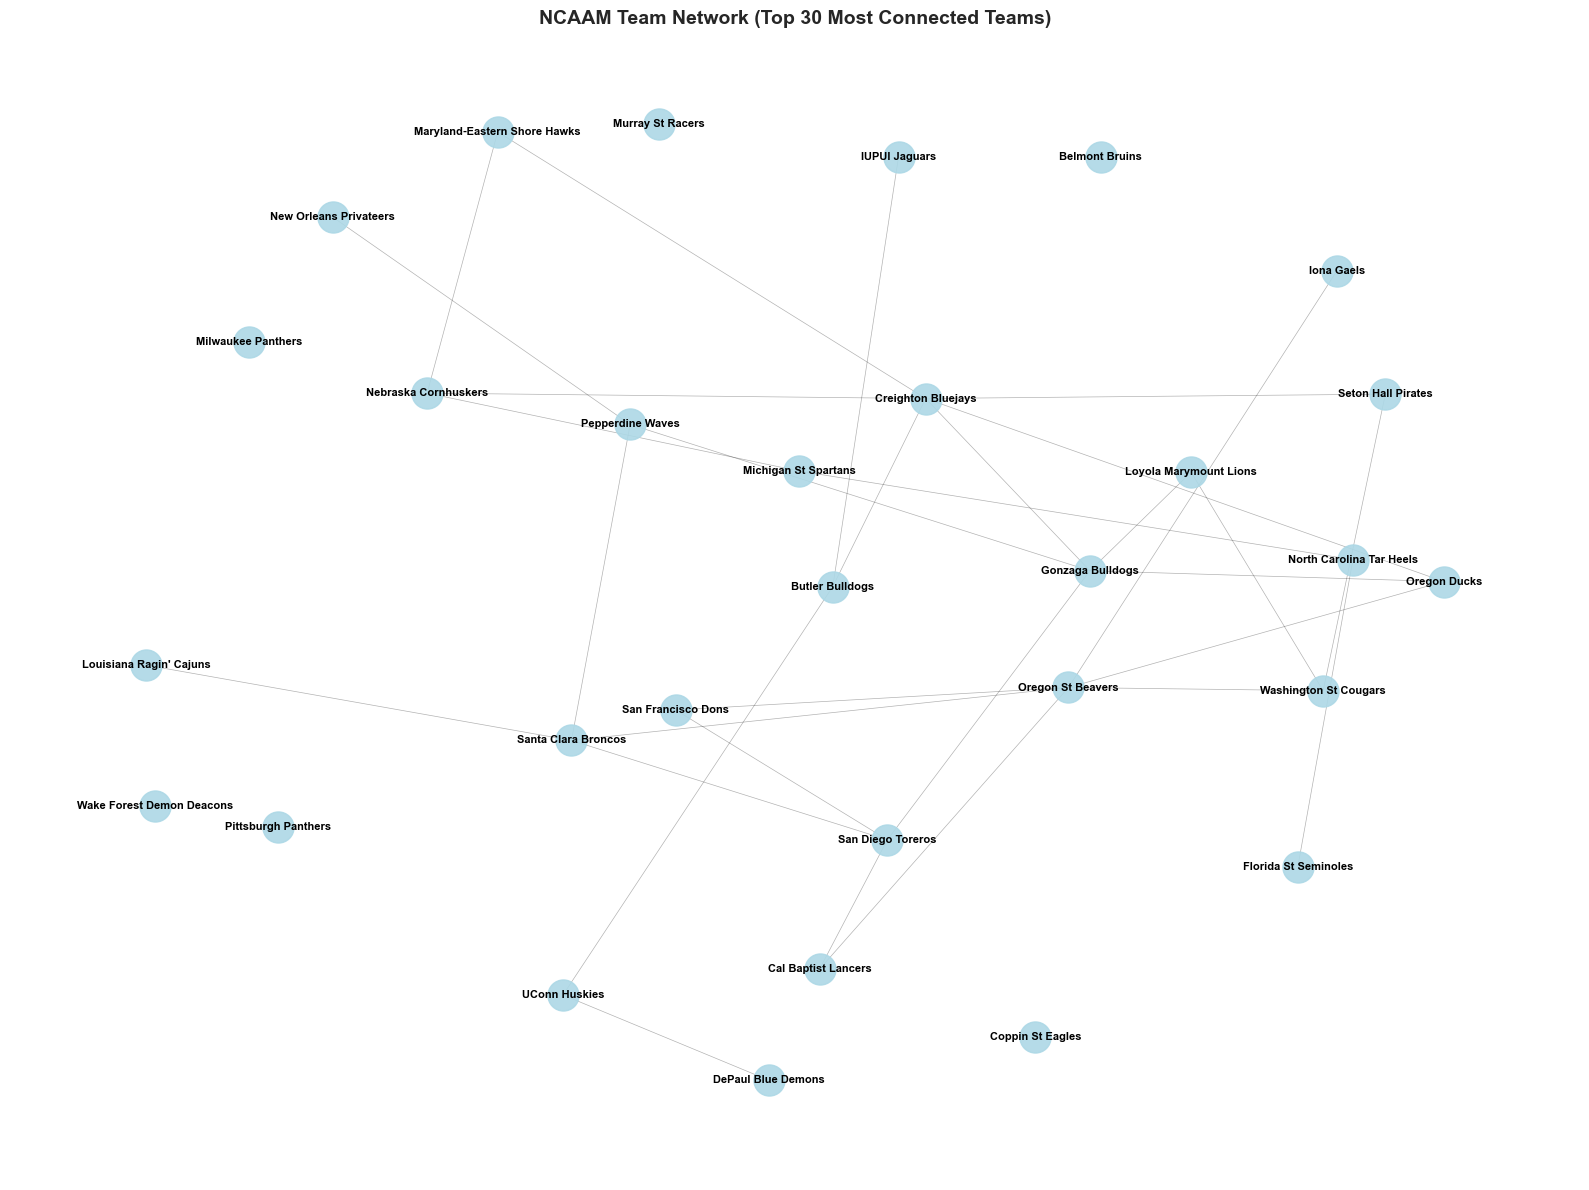

Network visualization shows 30 teams and 31 connections


In [7]:
# Create a sample network visualization (showing subset for readability)
# For full network, this would be too dense, so we'll show top teams by connectivity

top_teams = degree_df.head(30)['team'].tolist()
G_subset = G.subgraph(top_teams)

plt.figure(figsize=(16, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G_subset, k=1, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G_subset, pos, node_color='lightblue', 
                       node_size=500, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(G_subset, pos, alpha=0.3, width=0.5)

# Draw labels
nx.draw_networkx_labels(G_subset, pos, font_size=8, font_weight='bold')

plt.title('NCAAM Team Network (Top 30 Most Connected Teams)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Network visualization shows {len(G_subset.nodes())} teams and {len(G_subset.edges())} connections")
